In [1]:
seed = 66

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
np.set_printoptions(suppress=True)
np.random.seed(seed)
from mpl_toolkits.axes_grid1 import ImageGrid
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

import time

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from unet import UNetModel

import tqdm
import torch.nn.functional as F

##  Load Data

In [3]:
# In[2]

#Data Processing
data = pd.read_csv("F:data/BeijingLoad.csv", header=None)
ori_data = np.array(data)

#Gramian Angular Field
from pyts.image import GramianAngularField
transformer = GramianAngularField(sample_range=(0,1),method='s')

ori_gasf,scaled_data = transformer.transform(ori_data)

#ori_data——原始的365天负荷数据
#scaled_data——归一化后的365天负荷数据
#ori_gasf——完整的格拉姆角场图，365天
scaled_data = np.where(scaled_data>=1.,1.,scaled_data)
scaled_data = np.where(scaled_data<= -1.,-1.,scaled_data)

In [4]:
plt.rcParams['font.sans-serif'] = ['Times new Roman']
plt.rcParams['font.size'] = 12

In [5]:
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
new_transformer = GramianAngularField(sample_range=None,method='s')

In [7]:
#Data Split

train_set = scaled_data[:300]
test_set = scaled_data[300:]

batch_size = 20



In [8]:
def get_plot_data(x):
    x = x.cpu()
    x.squeeze_(1)
    x = np.array(x)
    return x

In [9]:
#取出GAF图像
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle = True,drop_last=True)

##  Train Diffusion Network

In [10]:
# Train network
net = UNetModel(image_size=24, in_channels=1, out_channels=1, 
                model_channels=64, num_res_blocks=2, channel_mult=(1,2,3,4),
                attention_resolutions=[8,4], num_heads=4).to(device)

net.load_state_dict(torch.load('unet_new.pth'))
net.to(device)
net.train()
print('Loaded model')

Loaded model


In [11]:
def compute_schedule(T, beta_min, beta_max, device):
    betas = torch.linspace(beta_min, beta_max, steps=T, device=device)
    alphas = 1 - betas

    std_t = torch.sqrt(betas)
    alpha_bar = torch.cumprod(alphas, dim=0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar)

    schedule_hparams = {
        "std_t": std_t,
        "alphas": alphas,
        "sqrt_alpha_bar": sqrt_alpha_bar,
        "sqrt_one_minus_alpha_bar": sqrt_one_minus_alpha_bar,
        "oneover_sqrta": 1 / torch.sqrt(alphas),
        "mab_over_sqrtmab": (1 - alphas) / sqrt_one_minus_alpha_bar,
    }
    return schedule_hparams

def sample(T, schedule, img_shape, unet, device):
    with torch.no_grad():
        seed = torch.randn(*img_shape).to(device=device)
        for i in range(T, 0, -1):
            z = torch.randn(*img_shape).to(device=device) if i > 1 else 0
            ts = torch.ones(1).to(device) * i

            pred_eps = net(seed, ts.float())
            term1 = schedule["oneover_sqrta"][i - 1]
            term2 = seed - (schedule["mab_over_sqrtmab"][i - 1] * pred_eps)
            term3 = z * schedule["std_t"][i - 1]

            seed = term1 * term2 + term3

        return seed

## Preparation

In [12]:
#mask generate
def sample_M(no, dim, miss_rate):
    A = np.random.uniform(0., 1., size = [no, dim])
    B = A > miss_rate
    C = 1.*B
    return torch.Tensor(C)

def mask_generate():
    mask_2d = np.zeros(shape = [batch_size,dim,dim])
    for i in range(mask_1d.shape[0]):
        mask_ = mask_1d[i]
        mask_x,mask_y = np.meshgrid(mask_,mask_)
        mask_2d[i] = mask_x*mask_y
    return torch.tensor(mask_2d,dtype=torch.float32)

In [13]:
batch_size = 20
dim = 24
miss_rate = 0.2

In [14]:
for scaled_data in train_loader:
    #完整图像
    imgs,_ = new_transformer.transform(scaled_data)
    #破损图像
    broke_data = scaled_data
    
    mask_1d = sample_M(batch_size,dim,miss_rate)
    
    broke_data[mask_1d==0] = 0.
    
    broke_imgs,_ = new_transformer.transform(broke_data)
    mask = mask_generate()
    
    imgs = torch.tensor(imgs,dtype=torch.float32)
    broke_imgs = torch.tensor(broke_imgs,dtype=torch.float32)
    
    imgs = imgs.unsqueeze(1)
    broke_imgs = broke_imgs.unsqueeze(1)
    mask = mask.unsqueeze(1)
    
    print(imgs.shape)
    print(broke_imgs.shape)
    print(mask.shape)
    
    print(imgs.dtype)
    print(broke_imgs.dtype)
    print(mask.dtype) 
    
    break

torch.Size([20, 1, 24, 24])
torch.Size([20, 1, 24, 24])
torch.Size([20, 1, 24, 24])
torch.float32
torch.float32
torch.float32


## Repair

In [15]:
# HyperParameters
T = 1000
beta_min = 1e-4
beta_max = 0.02
epochs = 100


device = "cuda" if torch.cuda.is_available() else "cpu"

schedule = compute_schedule(T, beta_min, beta_max, device)


In [34]:
U = 3

In [17]:
#取出1_d scaled data
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,drop_last=True)

In [18]:
for scaled_data in test_loader:
    #完整图像
    imgs,_ = new_transformer.transform(scaled_data)

    #破损图像
    broke_imgs = imgs.copy()
    
    mask_1d = sample_M(batch_size,dim,miss_rate)
    
    mask = mask_generate()
    
    broke_imgs[mask==0] = 0.
    '''
    imgs = torch.tensor(imgs,dtype=torch.float32)
    broke_imgs = torch.tensor(broke_imgs,dtype=torch.float32)
    
    imgs = imgs.unsqueeze(1)
    broke_imgs = broke_imgs.unsqueeze(1)
    mask = mask.unsqueeze(1)
    

    
    print(imgs.shape)
    print(broke_imgs.shape)
    print(mask.shape)
    
    print(imgs.dtype)
    print(broke_imgs.dtype)
    print(mask.dtype) 
    '''
    break

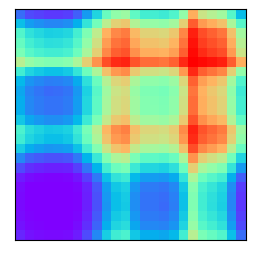

In [48]:
plt.figure(figsize=(3, 3))
    
plt.imshow(imgs[16],cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
ax = plt.gca()

ax.set_xticks([])
ax.set_yticks([])
#plt.savefig('resample_original.png')

In [37]:
imgs = get_plot_data(imgs)

In [29]:
broke_imgs = get_plot_data(broke_imgs)

In [30]:
broke_imgs.shape

(20, 24, 24)

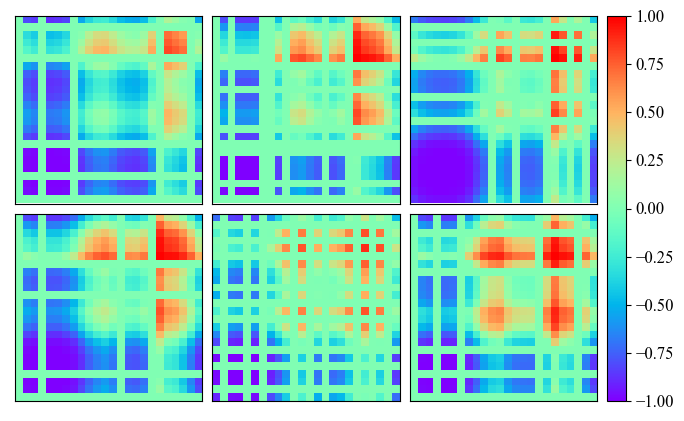

In [19]:
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(broke_imgs[i+12], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
'''
fig.suptitle("Corrupt GASF for the 12 time series in the "
             "'Beijing Load' dataset", y=0.92)
'''
#plt.savefig('broke_img.png')
plt.show()

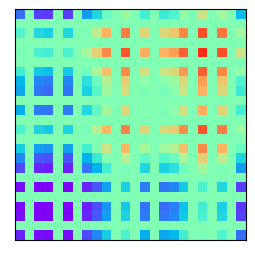

In [49]:
plt.figure(figsize=(3, 3))
    
plt.imshow(broke_imgs[16],cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
ax = plt.gca()

ax.set_xticks([])
ax.set_yticks([])

#plt.savefig('resample_mask.png')

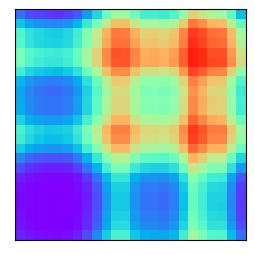

In [39]:
plt.figure(figsize=(3, 3))
    
plt.imshow(inpaint_data[16],cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
ax = plt.gca()

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('resample_u_11.png')

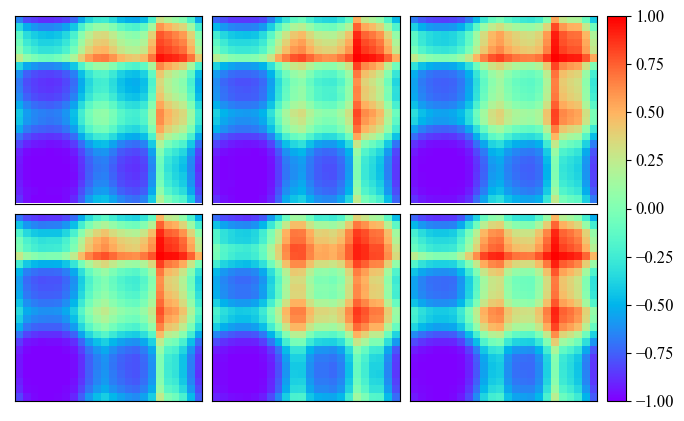

In [37]:
fig = plt.figure(figsize=(10, 5))

grid = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0.1, share_all=True,
                 cbar_mode='single')
for i, ax in enumerate(grid):
    im = ax.imshow(inpaint_data[i+12], cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])
plt.colorbar(im, cax=grid.cbar_axes[0])
ax.cax.toggle_label(True)
'''
fig.suptitle("Repair GASF for the 12 time series in the "
             "'Beijing Load' dataset", y=0.92)
'''
#plt.savefig('inpaint_img.png')
plt.show()

In [20]:
imgs = torch.tensor(imgs,dtype=torch.float32)
broke_imgs = torch.tensor(broke_imgs,dtype=torch.float32)

imgs = imgs.unsqueeze(1)
broke_imgs = broke_imgs.unsqueeze(1)
mask = mask.unsqueeze(1)

imgs = imgs.to(device)
broke_imgs = broke_imgs.to(device)
mask = mask.to(device)

In [35]:
x = imgs

In [36]:
seed = torch.randn_like(x, device=device)
  
with torch.no_grad():
        for t in range(T, 0, -1):
            for u in range(1, U+1):
                eps = torch.randn(
                    *x.shape, device=device) if t > 1 else torch.zeros(*x.shape, device=device)
                ts = torch.zeros(x.shape[0], device=device, dtype=torch.int64) + t

                # Known
                x_t_known = schedule["sqrt_alpha_bar"][ts - 1][..., None, None, None] * x + \
                    schedule["sqrt_one_minus_alpha_bar"][ts - 1][..., None, None, None] * eps
                
                # Unknown
                z = torch.randn(
                    *x.shape, device=device) if t > 1 else torch.zeros(*x.shape, device=device)

                pred_eps = net(seed, ts.float())
                term1 = schedule["oneover_sqrta"][t - 1]
                term2 = seed - (schedule["mab_over_sqrtmab"][t - 1] * pred_eps)
                term3 = z * schedule["std_t"][t - 1]
                x_t_unknown = term1 * term2 + term3
                
                # Compose
                composed = mask * x_t_known + (1-mask) * x_t_unknown
                
                if u < U and t > 1:
                    stdnorm = torch.randn_like(x, device=device)
                    composed = torch.sqrt(schedule["alphas"][t - 2]) * composed + torch.sqrt(
                        1 - schedule["alphas"][t - 2]) * stdnorm

                seed = composed
            print(t)

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

In [30]:
composed.shape

torch.Size([20, 1, 24, 24])

In [31]:
inpaint_data = get_plot_data(composed)

In [32]:
inpaint_data.shape

(20, 24, 24)

## Reverse

In [38]:
diag = np.random.random(size=[20,24])

In [39]:
for i in range(len(diag)):
    a = np.diag(inpaint_data[i])
    diag[i] = a

In [65]:
inpaint_data.shape

(20, 24, 24)

In [66]:
type(inpaint_data)

numpy.ndarray

In [71]:
isnan = np.isnan(diag)

In [72]:
print(True in isnan)

False


In [76]:
diag = np.where(diag>=1.,1.,diag)
diag = np.where(diag<= -1.,-1.,diag)

In [77]:
diag.shape

(20, 24)

In [78]:
np.min(diag)

-1.0

In [79]:
def reverse(x):
    phi = np.sqrt((x+1)/2)
    return phi

In [80]:
reverse_data = reverse(diag)

In [81]:
reverse_data.shape

(20, 24)

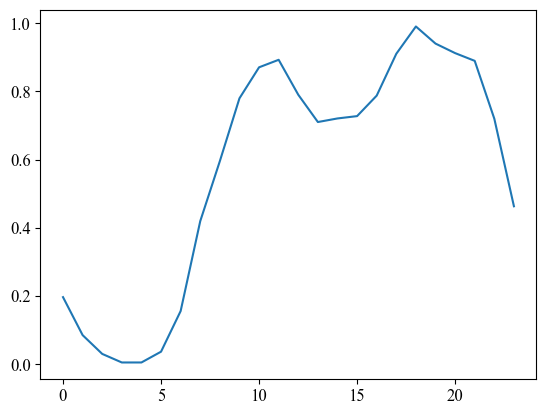

In [82]:
plt.plot(reverse_data[0])

In [83]:
ori_data.shape

(365, 24)

In [99]:
test_data_ = test_data.reshape(1,-1)

In [102]:
test_data_ = test_data_.squeeze(0)

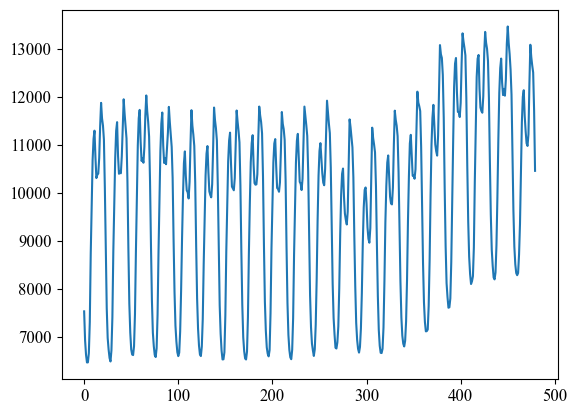

In [103]:
plt.plot(test_data_)

In [84]:
test_data = ori_data[300:320]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [85]:
scaled_test = scaler.fit_transform(test_data.T).T

In [86]:
reverse_denorm_data = scaler.inverse_transform(reverse_data.T).T

In [87]:
reverse_denorm_data.shape

(20, 24)

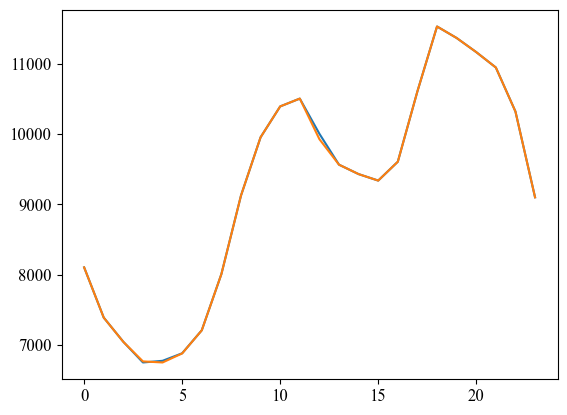

In [88]:
plt.plot(reverse_denorm_data[11])
plt.plot(test_data[11])

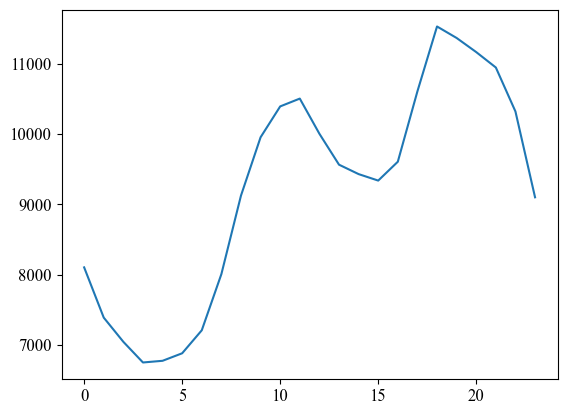

In [90]:
plt.plot(reverse_denorm_data[11])

In [91]:
reverse_denorm_data.shape

(20, 24)

In [93]:
draw_data = reverse_denorm_data.copy()

In [94]:
final_draw = draw_data[12:18,:]

In [95]:
final_draw.shape

(6, 24)

In [114]:
t = np.linspace(0,23,24)

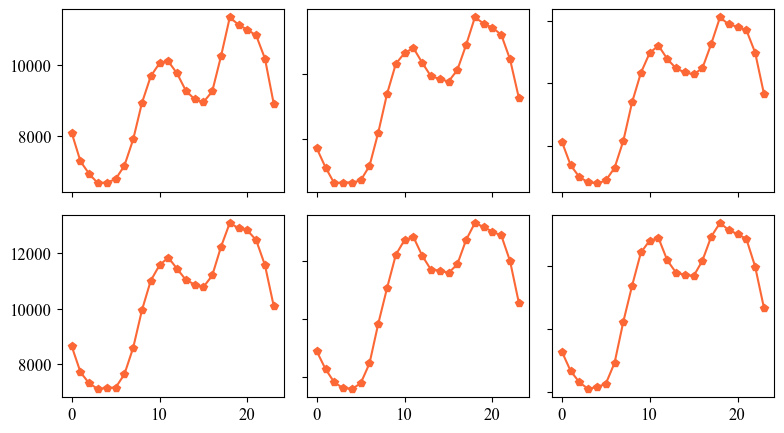

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(8,4.5))

axs[0, 0].plot(t, final_draw[0],'#FC6736',marker='p')
axs[0, 1].plot(t, final_draw[1],'#FC6736',marker='p')
axs[0, 2].plot(t, final_draw[2],'#FC6736',marker='p')
axs[1, 0].plot(t, final_draw[3],'#FC6736',marker='p')
axs[1, 1].plot(t, final_draw[4],'#FC6736',marker='p')
axs[1, 2].plot(t, final_draw[5],'#FC6736',marker='p')

'''
for ax in axs.flat:
    ax.set(xlabel='Time/h', ylabel='Load/kW',)
'''
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.tick_params(axis='both',labelsize=12)

for ax in axs.flat:
    ax.label_outer()

    
plt.tight_layout()
plt.savefig('imputed_1d.svg')
plt.show()

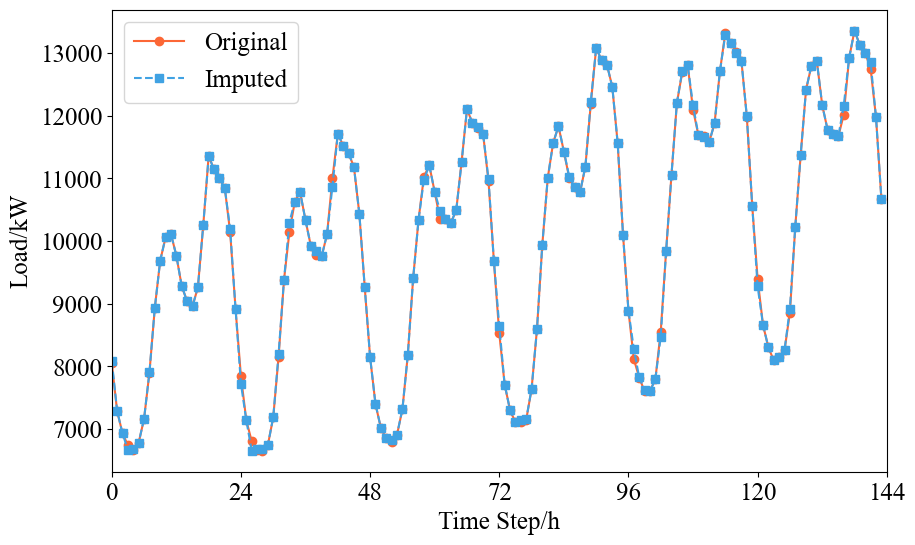

In [110]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 18,
}


plt.figure(figsize=(10, 6))

x = np.linspace(0,143,144)
original_data = test_data[12:18,:].reshape(1,-1)
original_data = original_data.squeeze(0)
imputed_data =final_draw.reshape(1,-1)
imputed_data = imputed_data.squeeze(0)

plt.xlim([0,144])
x_major_locator=MultipleLocator(24)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)


plt.xticks(fontproperties = 'Times New Roman', size = 18)
plt.yticks(fontproperties = 'Times New Roman', size = 18)

plt.ylabel("Load/kW",font)  # 设置Y轴标签
plt.xlabel("Time Step/h",font)  # 设置X轴标签


ln1, = plt.plot(x, original_data,color='#FC6736', marker='o', linestyle='-', label='original data')
ln2, = plt.plot(x, imputed_data,color='#40A2E3', marker='s', linestyle='--', label='imputed data ')

plt.legend([ln1,ln2],['original data','imputed data'],loc = 0)

ax.legend(labels = ['Original','Imputed'],loc = 0,prop = font)

#plt.show()

plt.savefig("1_D compare1.svg")